In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
%matplotlib inline

# Data Preprocessing

In [2]:
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

Drop galaxy with one observation:

In [3]:
train = train[train["galaxy"] != "NGC 5253"]

Seperate validation and prediction parts. For simple validation we'll use all data before year 1007012, as test index starts only from it.

In [4]:
VAL_MODE = False

if VAL_MODE:
    val_data = train[train["galactic year"] < 1007012].reset_index(drop=True)
    X = val_data.drop("y", axis=1)
    y = val_data["y"]
else:
    val_data = pd.concat([train, test], axis=0, sort=False, ignore_index=True)
    X = val_data.drop("y", axis=1)
    y = val_data["y"]

Encode galactic years using rank:

In [5]:
X["galactic year"] = X["galactic year"].rank(method="dense").astype(int)

Label-encode galaxies for convenience:

In [6]:
X["galaxy"], galaxy_names = X["galaxy"].factorize()

Set galaxy-year pair as index for data and answers:

In [7]:
X = X.set_index(["galaxy", "galactic year"])
idx_name = X.index
y.index = idx_name

For simple validation select 80 random galaxies (around number of galaxies in test for each year) and remove their answers from train for last 3 years.

In [8]:
if VAL_MODE:
    test_galaxies = X.index.get_level_values("galaxy").isin(X.reset_index("galaxy")["galaxy"][1].sample(80, random_state=42).values)
    test_years = X.index.get_level_values("galactic year") >= 15
    train_idx = X[~(test_years & test_galaxies)].index
    test_idx = X[(test_years & test_galaxies)].index
else:
    train_idx = X.index[:len(train)]
    test_idx = X.index[len(train):]

data = pd.concat([X, y.loc[train_idx]], axis=1)

Why use such a simple validation? Well, it may be better the nothing, but also if we saw, that distribution in test data changes significantly from train, and make it really hard to create something similar.

# Dynamic KNN Regression

The good thing is, we need only train answers to make quite good predictions. We have seen that answers movement between galaxies is very similar. Since we have answers for some galaxies in train for years, for which we don't have answers in test, for each galaxy in test we can find similar galaxies in train and use them to predict answer.

So, we will use KNN for prediction. But directly predicting an answer is not a good idea (which proved on validation), because, we can see similar movements, but values can be significantly different. The better strategy is to predict a change in answer for each galaxy and add it to last known value to get the answer. The algorithm is following:

For each year that we have to make predictions for:
- Take all answers for all galaxies till this year
- Differentiate answers for each galaxy in time
- If galaxy has answer for current year, it goes to train, else to test
- For each galaxy in test:
 - Find $K$ nearest galaxies in train in terms of differences
 - Average current differences of neighbors to predict difference in this galaxy
 - Add predicted difference to previous value to obtain final value prediction

This way, on each step we will have fully completed predictions till current year.

(Optimal parameters for KNN were obtained during validation)

In [9]:
pred = data["y"].copy()
pred_years = sorted(data["y"][data["y"].isna()].index.get_level_values("galactic year").unique())
if not VAL_MODE:
    pred_years = pred_years[:-1]

for pred_year in pred_years:
    print(f"Prediction for year {pred_year}")
    knn_data = pred.unstack().diff(axis=1).iloc[:, :pred_year]
    knn_data.iloc[:, 0].fillna(0, inplace=True)
    knn_data = knn_data[~knn_data.iloc[:, :-1].isna().any(axis=1)]

    X_train = knn_data[~knn_data.isna().any(axis=1)].iloc[:, :-1]
    y_train = knn_data[~knn_data.isna().any(axis=1)].iloc[:, -1]

    X_pred = knn_data[knn_data.isna().any(axis=1)].iloc[:, :-1]

    model = KNeighborsRegressor(12, weights="distance", p=1.5)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_pred)
    y_pred = pd.Series(y_pred, index=X_pred.index)

    knn_data.iloc[:, -1].fillna(y_pred, inplace=True)

    pred = pred.fillna(knn_data.cumsum(axis=1).add(pred.unstack()[1], axis=0).stack())

test_pred = pred[test_idx]
train_pred = pred[train_idx]

Prediction for year 18
Prediction for year 19
Prediction for year 20
Prediction for year 21
Prediction for year 22
Prediction for year 23
Prediction for year 24
Prediction for year 25
Prediction for year 26


As it can be seen on validation, prediction of difference is quite good, but the main problem is, if we make an error in one of the first years of prediction, it will propogate to all of the following years predictions, i.e. in galaxy 147.

Another problem with this approach is that in train we don't have train answers for last year in test (27), thus, cannot use KNN. But we can simply forward-fill last predictions:

In [10]:
# Forward fill last value if predicting test
if not VAL_MODE:
    pred = pred.unstack().ffill(axis=1).stack()
    test_pred = pred[test_idx]
    train_pred = pred[train_idx]

In [11]:
train_error = mean_squared_error(y.loc[train_idx], train_pred, squared=False)
print("Train RMSE:", train_error)
if VAL_MODE:
    test_error = mean_squared_error(y.loc[test_idx], test_pred, squared=False)
    print("Test RMSE:", test_error)

Train RMSE: 0.0


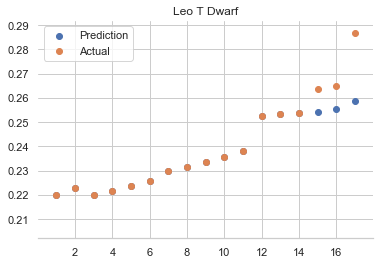

In [21]:
galaxy_id = 147
sample_pred = pred.unstack().iloc[galaxy_id]
sample_y = y.unstack().iloc[galaxy_id]
plt.scatter(sample_pred.index, sample_pred, label="Prediction")
plt.scatter(sample_y.index, sample_y, label="Actual")
plt.title(galaxy_names[galaxy_id])
plt.legend()
sns.despine(left=True)
plt.show()

# Analyzing prediction

Let's have a look at what we've predicted on sample of galaxies:

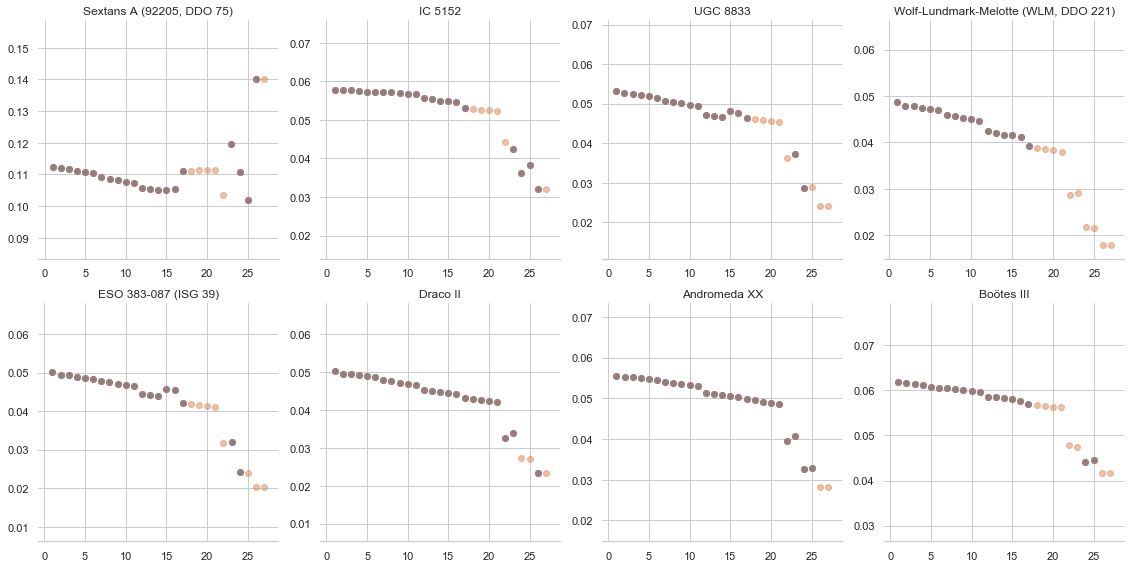

In [12]:
np.random.seed(0)
sample_galaxies = np.random.choice(X.loc[test_idx].index.get_level_values("galaxy"), 8, replace=False)

fig, axes = plt.subplots(int(np.ceil(len(sample_galaxies) / 4)), 4, figsize=(16, 8))
for galaxy, ax in zip(sample_galaxies, axes.flatten()):
    galaxy_data = data.loc[galaxy]
    ax.set_title(galaxy_names[galaxy])
    ax.scatter(galaxy_data.index, galaxy_data["y"])
    if galaxy in pred:
        galaxy_pred_data = pred[galaxy]
        ax.scatter(galaxy_pred_data.index, galaxy_pred_data.values, alpha=0.5)
    if VAL_MODE and (galaxy in y.loc[test_idx].index.get_level_values("galaxy")):
        galaxy_test_data = y.loc[test_idx][galaxy]
        ax.scatter(galaxy_test_data.index, galaxy_test_data.values, alpha=0.5, c="b")
sns.despine(left=True)
plt.tight_layout()

Looks realistic!

# Optimal allocation

Some stuff needed to check constraints and compute potential:

In [13]:
low_eei_idx = test[test["existence expectancy index"] < 0.7].index

potential = -np.log(test_pred.values + 0.01) + 3

def neg_likely_increase(w):
    return -(w * potential ** 2).sum() / 1000

Ideally we would allocate 100 to top 500 galaxies by their potential, but let's have a look at our predictions distribution:

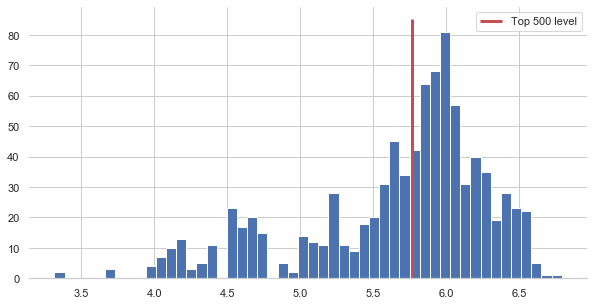

In [14]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(potential, bins=50)
ax.vlines(sorted(potential)[-500], ax.get_ylim()[0], ax.get_ylim()[1], label="Top 500 level", color="r", lw=3)
ax.legend()
sns.despine(left=True)
plt.show()

We can see that there are a lot of predictions in border area, so we can easily make a mistake even if a prediction is quite good, and get a bad score for optimization. To overcome it, we will gradually decrease allocated stuff around borderline.

First way to allocate is to decrease quantity linearly. Several submissions helped to find near-optimal area for dilution, which is around 125 galaxies around border:

In [15]:
x1 = np.zeros(len(test))
x1[potential.argsort()[::-1][:375]] = 100
x1[potential.argsort()[::-1][375:625]] = [100 - i * (50 / 125) for i in range(1, 126)] + [100 - i  * (50 / 125) for i in range(125, 250)]
print("Total low-EEI galaxies energy:", x1[low_eei_idx].sum())
print("Likely increase:", -neg_likely_increase(x1))

Total low-EEI galaxies energy: 6455.2
Likely increase: 1857.859277249552


Second way takes into account that in equal range around border, we have more predictions greater then border, then predictions less than border, so we need to dilute them more aggresively:

In [16]:
h = 62.5
x2 = np.zeros(len(test))
x2[potential.argsort()[::-1][:250]] = 100
x2[potential.argsort()[::-1][250:500]] = [100 - i / 250 * (100 - h) for i in range(1, 251)]
x2[potential.argsort()[::-1][500:650]] = [1/3 + h - i / 150 * h for i in range(1, 151)]
print("Total low-EEI galaxies energy:", x2[low_eei_idx].sum())
print("Likely increase:", -neg_likely_increase(x2))

Total low-EEI galaxies energy: 6243.849999999999
Likely increase: 1852.2509148368479


Final submission averages these approaches:

In [17]:
x = (x1 + x2) / 2

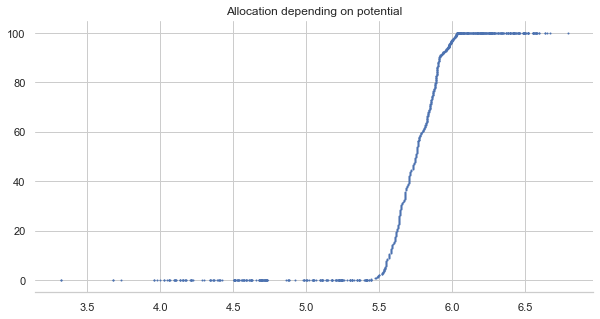

In [18]:
plt.figure(figsize=(10, 5))
plt.title("Allocation depending on potential")
plt.scatter(potential, x, s=1)
sns.despine(left=True)
plt.show()

In [19]:
print(f"Total allocated value: {x.sum()}")

Total allocated value: 49999.99999999999


# Creating submission

In [20]:
result = pd.DataFrame(columns=["Index", "pred", "opt_pred"])
result["Index"] = test.index
result["pred"] = test_pred.values
result["opt_pred"] = x

In [21]:
result.to_csv("../submissions/submission.csv", index=False)